## Requirements

In [1]:
import matplotlib.pyplot as plt
import random
import timeit

## Problem setting

Consider a database consisting of intervals over the positive integers, i.e., each element in the database is a half-open interval $d_i = [d_{i,s}, d_{i,e})$.  The database can be represented as $D = \{d_i | i \in [0, M)\}$, so $|D| = M$.  Clearly, for each interval $d_i$, $d_{i,e} > d{i, s} + 1$.

An intersection query is based on a query interval $q = [q_s, q_e)$ with $q_e > q_s + 1$; the query returns all intervals in $D$ that query interval intersects, i.e.,
$$
  \{ d | d \in D \wedge q_s < d_e \wedge d_s < q_e\}
$$

Rather than querying for a single interval, $N$ intervals are queried, the set of query intervals is denoted by $Q$.  The result of such a query is given by
$$
  \{(q, d) | (q, d) \in Q \times D \wedge q_s < d_e \wedge d_s < q_e\}
$$

## Database and queries

Define some type aliases to give more structure to the code.

In [2]:
%pycat naive_pythonic_intersectionic_queries.py

'''
Naive and very Pythonic implementation of interval intersection queries.
'''

import collections
import itertools
import random
import typing


Interval = collections.namedtuple('Interval', ('s', 'e'))
Db: typing.TypeAlias = set[Interval]
Queries: typing.TypeAlias = Db
QueryResult: typing.TypeAlias = set[tuple[Interval, Interval]]


def generate_interval(max_end: int = 1_000_000_000) -> Interval:
    '''Generate a half-open interval of at least length 1
    
    Parameters
    ----------
    max_end: int
        largest end value of the interval, default value 1_000_000_000
        
    Returns
    -------
    Interval
        Tuple (start, end) such that end - start > 1
    '''
    start = random.randint(0, max_end - 2)
    end = random.randint(start + 2, max_end)
    return Interval(s=start, e=end)


def create_db(size: int = 1_000, max_end: int = 1_000_000) -> Db:
    '''Generate a database of intervals
    
    Parameters
    ----------
    size: int
        number of intervals

In [3]:
import naive_pythonic_intersectionic_queries

In [4]:
naive_pythonic_intersectionic_queries.create_db(size=10, max_end=100)

{Interval(s=9, e=64),
 Interval(s=18, e=37),
 Interval(s=20, e=42),
 Interval(s=26, e=28),
 Interval(s=26, e=86),
 Interval(s=30, e=76),
 Interval(s=46, e=80),
 Interval(s=66, e=91),
 Interval(s=67, e=91),
 Interval(s=83, e=87)}

For benchmarking, these parameters are used.

In [5]:
sizes = [2**i for i in range(7, 14)]
nr_repeats = 5

## Naive approach

A very simple but naive approach is to check overlap of each query interval with every database interval resulting in $|Q| \times |D|$ queries>

In [6]:
random.seed(1234)
naive_pythonic_times = [
    timeit.repeat(
        stmt='naive_pythonic_intersectionic_queries.execute_queries(queries, db)',
        setup=f'queries, db = naive_pythonic_intersectionic_queries.create_queries({size}), naive_pythonic_intersectionic_queries.create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

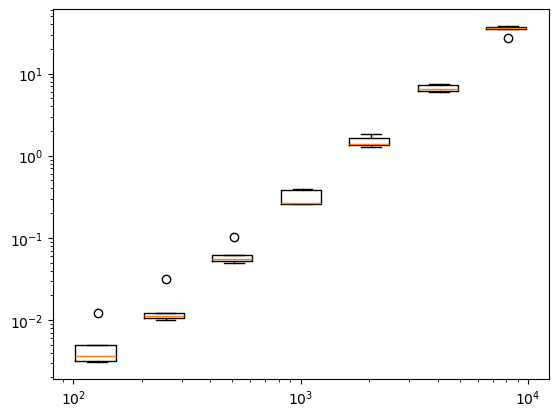

In [7]:
plt.boxplot(naive_pythonic_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.xscale('log')
plt.yscale('log');

The time complexity of this algorithm is $N^2$ for $|D| = |Q| = N$.

In [8]:
import naive_intersectionic_queries

In [9]:
random.seed(1234)
naive_times = [
    timeit.repeat(
        stmt='naive_intersectionic_queries.execute_queries(queries, db)',
        setup=f'queries, db = naive_intersectionic_queries.create_queries({size}), naive_intersectionic_queries.create_db({size})',
        repeat=nr_repeats,
        number=1,
        globals=globals(),
    ) for size in sizes
]

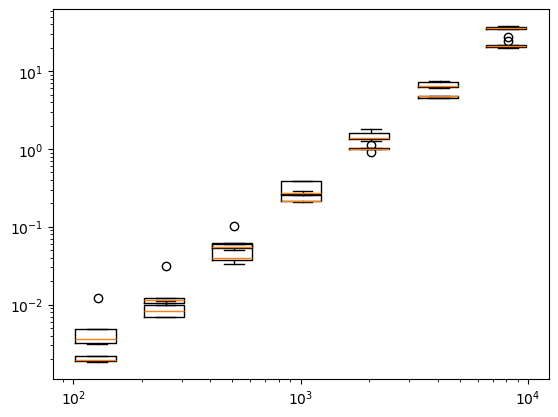

In [10]:
plt.boxplot(naive_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.boxplot(naive_pythonic_times, widths=[40.0*size/100 for size in sizes], positions=sizes)
plt.xscale('log')
plt.yscale('log');

In [11]:
naive_times[-1]

[24.168750459000876,
 20.618894384999294,
 19.991639296000358,
 21.888372638000874,
 21.239045664000514]

In [12]:
naive_pythonic_times[-1]

[35.3211215249994,
 38.21256336699844,
 36.7637766250009,
 35.53419433499948,
 27.104355830000713]